# 유도변수: vorticity
- 재분석자료의 vorticity와 그 advection을 계산
- https://unidata.github.io/python-training/gallery/500hpa_vorticity_advection/ 참조

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import scipy.ndimage as ndimage

from metpy.units import units
from datetime import datetime
import xarray as xr

In [2]:
ds = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa', 'level':500}})

In [10]:
# Get lat/lon data from file
lats = ds.latitude.data[10:91]
lons = ds.longitude.data[60:191]

# Get variables and smooth
z_500 = ds['gh'].sel(latitude=lats, longitude=lons) * units('m')
u_500 = ds['u'].sel(latitude=lats, longitude=lons)* units('m/s')
v_500 = ds['v'].sel(latitude=lats, longitude=lons)* units('m/s')


f = mpcalc.coriolis_parameter(np.deg2rad(lats)).reshape(len(lats),1).to(units('1/sec'))
vor = mpcalc.vorticity(u_500, v_500)
avor = vor + f
vort_adv = mpcalc.advection(avor, u_500, v_500) * 1e10
z_500, vor, avor, vort_adv = map(lambda x: ndimage.gaussian_filter(x, sigma=3, order=0), [z_500, vor, avor, vort_adv])

# Get time in a nice datetime object format
vtime = ds.time.values.astype('str')[:13]

In [14]:
u_500.data

Magnitude,[[17.860273361206055 17.050273895263672 16.200273513793945 ... -4.68972635269165 -5.169726371765137 -5.74972677230835] [13.610273361206055 12.630273818969727 12.320273399353027 ... -4.139726638793945 -4.289726734161377 -4.959726333618164] [9.540273666381836 9.050273895263672 8.570273399353027 ... -5.149726390838623 -5.529726505279541 -5.859726428985596] ... [-5.449726581573486 -5.669726371765137 -4.93972635269165 ... -4.449726581573486 -3.089726448059082 -3.5497264862060547] [-5.43972635269165 -5.669726371765137 -4.819726467132568 ... -5.569726467132568 -4.74972677230835 -4.639726638793945] [-3.529726505279541 -3.3197264671325684 -3.159726619720459 ... -5.709726333618164 -4.849726676940918 -4.789726734161377]]
Units,meter/second


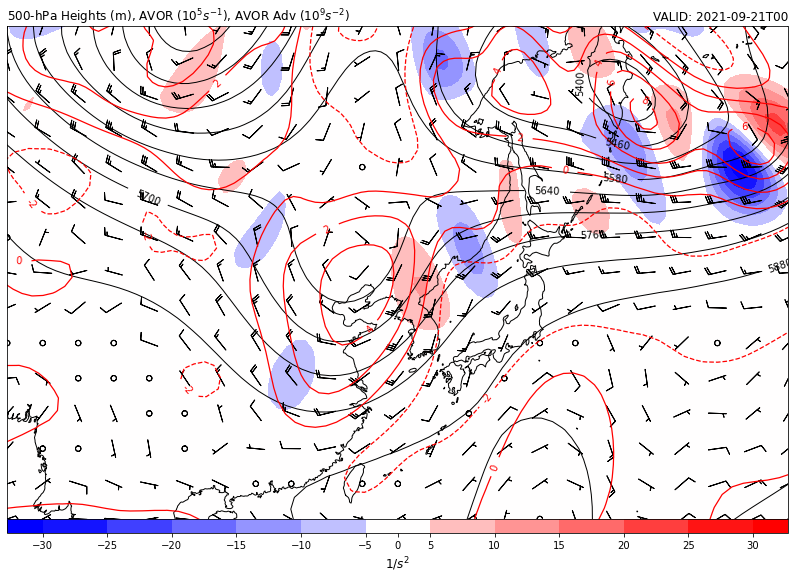

In [21]:
# Set up Coordinate System for Plot and Transforms

mapcrs = ccrs.LambertConformal(central_longitude=125, central_latitude=35,
                               standard_parallels=(30, 60))
datacrs = ccrs.PlateCarree()

# Plot Background
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

# Plot Titles
plt.title(r'500-hPa Heights (m), AVOR ($10^{5} s^{-1}$), AVOR Adv ($10^{9} s^{-2}$)',
          loc='left')
plt.title(f'VALID: {vtime}', loc='right')

# Plot Height Contours
clev500 = np.arange(4800, 6061, 60)
cs = ax.contour(lons, lats, z_500, clev500, colors='black', linewidths=1.0,
                linestyles='solid', transform=ccrs.PlateCarree())
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Absolute Vorticity Contours
clevvort500 = np.arange(-20, 21, 2)
cs2 = ax.contour(lons, lats, vor*10**5, clevvort500, colors='red',
                 linewidths=1.25, transform=ccrs.PlateCarree())
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Vorticity Advection
clev_avoradv = np.arange(-30, 31, 5)
cf = ax.contourf(lons, lats, vort_adv, clev_avoradv[clev_avoradv != 0], extend='both',
                 cmap='bwr', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, ax=ax, orientation='horizontal', extendrect='True', ticks=clev_avoradv, pad=0, aspect=50)
cb.set_label(r'$1/s^2$', size='large')

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
ax.barbs(lons, lats, u_500.data, v_500.data, length=6, regrid_shape=15,
         pivot='middle', transform=ccrs.PlateCarree())